***DISCLAIMER:***

This code was supplied by tommarvoloriddle and can be found at: https://github.com/tommarvoloriddle/Bilinear-CNN-Tensorflow2.4-implementation.  

Our changes include:

   1)  Adding the first cell below importing Google Colab drive and zipfile.  These changes were necessary for us to run our model and train it with our datasets on Google Colab.

   2)  Importing Pillow's Image and ImageFile.  This allowed us to use Google Colab for some of our larger datasets.

   3)  Our final change is in the model structure.  We had to change the size of the output layer to reflect how many classes we had as possible classification solutions. 

   4)  We edited filepaths to point to the directories of our choice where applicable. 


  For any further questions please contact: William Connor Parham, Abdurhman Bahour, or Coby White at the following respective emails: wparham1@vols.utk.edu, abahour2@vols.utk.edu, or cwhit152@vols.utk.edu


In [ ]:
from google.colab import drive
from zipfile import ZipFile 

drive.mount('/content/drive', force_remount=True) 


file_name = '/content/drive/MyDrive/Stanford Dogs edited.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

file_name = '/content/drive/MyDrive/stanford cats small.zip'
# file_name = "/content/Stanford Dogs edited.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

Mounted at /content/drive


In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
!ls 

'20p cats 80p dogs'   model_bilin_dropout  'stanford cats'	'Stanford Dogs'
 drive		      sample_data	   'stanford combined'


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib as mpl
import cv2
import time
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
#from keras.initializers import glorot_normal
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
from matplotlib import pyplot
#from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
"""
Calculates dot product of x[0] and x[1] for mini_batch 

Assuming both have same size and shape

@param
x -> [ (size_minibatch, total_pixels, size_filter), (size_minibatch, total_pixels, size_filter) ]

"""
def dot_product(x):

    return keras.backend.batch_dot(x[0], x[1], axes=[1,1]) / x[0].get_shape().as_list()[1] 

"""
Calculate signed square root

@param
x -> a tensor

"""

def signed_sqrt(x):

    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

"""
Calculate L2-norm

@param
x -> a tensor

"""

def L2_norm(x, axis=-1):

    return keras.backend.l2_normalize(x, axis=axis)

In [ ]:
'''

    Take outputs of last layer of VGG and Droput 50% 
    load it into Lambda layer which calculates outer product.
    
    Here both bi-linear branches have same shape.
    
    z -> output shape tuple
    x -> outpur og VGG tensor
    y -> copy of x as we modify x, we use x, y for outer product.
    
'''

def build_model():
    tensor_input = keras.layers.Input(shape=[150,150,3])
    
    model1 = tf.keras.models.Sequential()
    model1 = layers.Conv2D(64, (3, 3), activation='relu')(tensor_input)
    model1 = (layers.MaxPooling2D((2, 2)))(model1)
    model1 = (layers.Conv2D(128, (3, 3), activation='relu'))(model1)
    model1 = (layers.MaxPooling2D((2, 2)))(model1)
    model1 = (layers.Conv2D(128, (3, 3), activation='relu'))(model1)
    model1 = keras.models.Model(inputs=tensor_input, outputs = model1)
    
    #print(model1.summary())

    
    model2 = tf.keras.models.Sequential()
    model2 = layers.Conv2D(64, (3, 3), activation='relu')(tensor_input)
    model2 = (layers.MaxPooling2D((2, 2)))(model2)
    model2 = (layers.Conv2D(128, (3, 3), activation='relu'))(model2)
    model2 = (layers.MaxPooling2D((2, 2)))(model2)
    model2 = (layers.Conv2D(128, (3, 3), activation='relu'))(model2)
    model2 = keras.models.Model(inputs=tensor_input, outputs = model2)

    #print(model2.summary())
    
    x = model1.output
    z = model2.output_shape
    y = model2.output
    

#   rehape to (batch_size, total_pixels, filter_size)
    x = keras.layers.Reshape([z[1] * z[2] , z[-1]])(x)
        
    y = keras.layers.Reshape([z[1] * z[2] , z[-1]])(y)
    
#   outer products of x, y
    x = keras.layers.Lambda(dot_product)([x, y])
    
#   rehape to (batch_size, filter_size_vgg_last_layer*filter_vgg_last_layer)
    x = keras.layers.Reshape([z[-1]*z[-1]])(x)
        
#   signed_sqrt
    x = keras.layers.Lambda(signed_sqrt)(x)
        
#   L2_norm
    x = keras.layers.Lambda(L2_norm)(x)

#   FC-Layer

    initializer = tf.keras.initializers.GlorotNormal()
            
    x = keras.layers.Dense(units=120, 
                           kernel_regularizer=keras.regularizers.l2(0.0),
                           kernel_initializer=initializer)(x)

    tensor_prediction = keras.layers.Activation("softmax")(x)

    model_bilinear = keras.models.Model(inputs=[tensor_input],
                                        outputs=[tensor_prediction])
    


    # sgd = keras.optimizers.SGD(learning_rate=1.0, 
    #                            decay=0.0,
    #                            momentum=0.9)

    sgd = tf.keras.optimizers.legacy.SGD(learning_rate=1.0,
                                          decay=0.0,
                                          momentum=0.9)

    model_bilinear.compile(loss="categorical_crossentropy", 
                           optimizer=sgd,
                           metrics=["categorical_accuracy"])

    #model_bilinear.summary()
    
    return model_bilinear

In [ ]:
model = build_model()

In [ ]:
train_datagen = image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        '/content/Stanford Dogs/train',
        target_size=(150, 150),
        color_mode="rgb",
        batch_size=32,
        subset='training',
        class_mode='categorical')
val_generator = test_datagen.flow_from_directory(
        '/content/Stanford Dogs/validation',
        target_size=(150, 150),
        color_mode="rgb",
        batch_size=32,
        subset='training',
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        '/content/Stanford Dogs/test',
        target_size=(150, 150),
        color_mode="rgb",
        shuffle = False,
        class_mode=None,
        batch_size=1)

Found 10122 images belonging to 120 classes.
Found 2333 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


In [ ]:

def train_model(epochs):

    hist = model.fit(
                x=train_generator, 
                epochs=epochs, 
                validation_data=val_generator,
                workers=1,
                verbose=1
            )
    
    return hist

#     model.save_weights("./bilinear_weights/val_acc_" + str(hist.history['val_categorical_accuracy'][-1]) +"_"+ str(epochs)+ ".h5")

In [ ]:
hist=train_model(epochs=1)

317/317 [==============================] - 79s 248ms/step - loss: 4.9059 - categorical_accuracy: 0.0088 - val_loss: 4.8925 - val_categorical_accuracy: 0.0069


In [ ]:
for layer in model.layers:
    layer.trainable = True

sgd = keras.optimizers.legacy.SGD(learning_rate=1e-3, decay=1e-9, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["categorical_accuracy"])

In [ ]:
# hist =train_model(epochs=1)

In [ ]:
model.save('./model_bilin_dropout')

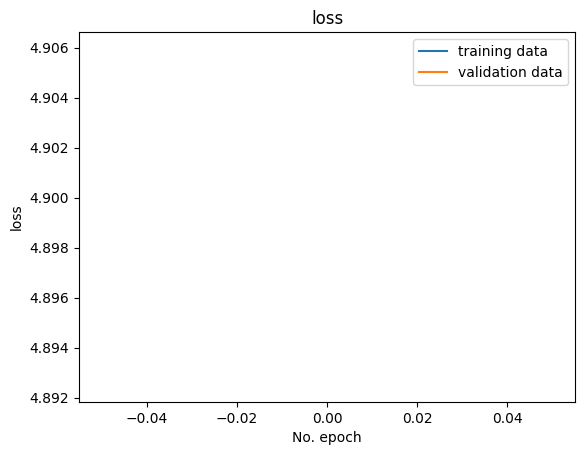

In [ ]:
# Plot history: MAE
plt.plot(model.history.history['loss'], label='training data')
plt.plot(model.history.history['val_loss'], label='validation data')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
preds = model.predict_generator(test_generator, verbose=1)

   1/8580 [..............................] - ETA: 20:40

<ipython-input-74-9fcdc20f29af>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, verbose=1)


8580/8580 [==============================] - 33s 4ms/step


In [ ]:
preds_cls_idx = preds.argmax(axis=-1)
preds_cls_idx

array([80, 80, 80, ..., 80, 80, 80])

In [ ]:
idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
preds_cls

array(['n02106030-collie', 'n02106030-collie', 'n02106030-collie', ...,
       'n02106030-collie', 'n02106030-collie', 'n02106030-collie'],
      dtype='<U16')

In [ ]:
true_lables = []
true_lables_upc_idx_map = {}
true_lables_img = {}
upc_list = os.listdir('/content/Stanford Dogs/test')
idx = 0
for upc in upc_list:
    img_folder = '/content/Stanford Dogs/test/' + upc +'/'
    img_list = os.listdir(img_folder)
    for img in img_list:
        true_lables.append(upc)
        true_lables_upc_idx_map[idx] = upc
        true_lables_img[idx] = img
        idx += 1
len(true_lables)

8580

In [ ]:
wrong_predicted = []
count = 0
for idx in range(0, len(preds_cls)):
    if preds_cls[idx] != true_lables[idx]:
        wrong_predicted.append(idx)
    else:
        count += 1
count

53

In [ ]:
len(wrong_predicted)

8527

In [ ]:
accuracy = count/len(preds_cls)
accuracy

0.006177156177156177

In [ ]:
wrong_pred_upc = set()
for label in wrong_predicted:
    wrong_pred_upc.add(true_lables_upc_idx_map[label])
len(wrong_pred_upc), len(wrong_predicted)

(119, 8527)

In [ ]:
images_pred_wrong = []
for label in wrong_predicted:
    images_pred_wrong.append(true_lables_img[label])
len(images_pred_wrong)

8527

In [ ]:
d={}
for i in range(0 ,len(images_pred_wrong)):
    if preds_cls[i] not in d.keys():
        d[preds_cls[i]] = 1
    else:
        d[preds_cls[i]] += 1
d, len(d)

({'n02106030-collie': 8527}, 1)

In [ ]:
for i in range(0 ,len(images_pred_wrong)):
    img ='/content/Stanford Dogs/test/' + true_lables_upc_idx_map[wrong_predicted[i]] + '/' + images_pred_wrong[i]
    #print(img, preds_cls[i])

In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

In [ ]:
f1 = f1_score(true_lables, preds_cls, average='weighted')
precision = precision_score(true_lables, preds_cls, average='weighted')
recall  = recall_score(true_lables, preds_cls, average='weighted')
accuracy = accuracy_score(true_lables, preds_cls)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("f1 :", f1)
print("precision :", precision)
print("recall :", recall)
print("accuracy :", accuracy)

f1 : 7.584600426022876e-05
precision : 3.815725843697872e-05
recall : 0.006177156177156177
accuracy : 0.006177156177156177
